# Init

In [1]:
import os
import operator
import csv
import json
import datetime as dt
import numpy as np
import pandas as pd
import math
import random
import scipy

from sklearn.preprocessing import normalize
from scipy.optimize import minimize

## Plotting

In [2]:
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.patheffects as path_effects

import seaborn as sns

In [3]:
plt.rcParams["font.family"] = 'Courier'
%matplotlib inline

In [4]:
set([f.name for f in matplotlib.font_manager.fontManager.afmlist])

{'Computer Modern',
 'Courier',
 'Helvetica',
 'ITC Avant Garde Gothic',
 'ITC Bookman',
 'ITC Zapf Chancery',
 'ITC Zapf Dingbats',
 'New Century Schoolbook',
 'Palatino',
 'Symbol',
 'Times',
 'Utopia',
 'ZapfDingbats'}

## Original run settings

In [5]:
year_series = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [6]:
data_procecing_run = '19-ext'
number_of_topics = 22
original_run_prefix = 'run_%s_%s' % (data_procecing_run, number_of_topics)

## Paths

In [7]:
PATHS = {}

PATHS['root'] = os.path.join('..')
PATHS['tickers'] = os.path.join(PATHS['root'], 'data_processing', 'tickers')
PATHS['runs'] = os.path.join(PATHS['root'], 'data_runs')
PATHS['original_run'] = os.path.join(PATHS['runs'], original_run_prefix)
PATHS['original_dtm_results'] = os.path.join(PATHS['original_run'], 'results', 'lda-seq')
PATHS['original_run_interpretation'] = os.path.join(PATHS['original_run'], 'interpretation')
PATHS['original_run_returns'] = os.path.join(PATHS['original_run_interpretation'], 'return')
PATHS['runs_n-1'] = os.path.join(PATHS['runs'], 'run_n-1')


PATHS['src'] = os.path.join(PATHS['root'], 'src')



In [8]:
FILES = {}
FILES['return_coeficients'] = os.path.join(PATHS['original_run'], '%s-returns.csv' % original_run_prefix)
FILES['tickers'] = os.path.join(PATHS['tickers'], 'ticker_for_analysis.csv')
FILES['tickers_names'] = os.path.join(PATHS['tickers'], 'tickers_names_map.csv')


In [9]:
import sys

sys.path.insert(0, PATHS['src'])
print(sys.path)

['../src', '/Users/Alan_Spark/Projects/research/dtm-reports-analysis/notebooks', '/Users/Alan_Spark/Projects/tensorflow/models/research', '/Users/Alan_Spark/Projects/research/dtm-reports-analysis/notebooks', '/Users/Alan_Spark/opt/anaconda3/lib/python37.zip', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/lib-dynload', '', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/Alan_Spark/.ipython']


## Flags 

In [10]:
FLAGS = {}
FLAGS['plot monochrome'] = False

# Get top words original run

In [11]:
top_words = [
    'chase, mortgage, collar',
    'reinsurance, casualty, policyholder',
    'electricity, semiconductor, renewable',
    'passenger, aircraft, air',
    'medical, patient, hospital',
    'registration, subscription, client',
    'mine, mining, copper',
    'hotel, restaurant, store',
    'mobile, wireless, spectrum topic',
    'sky, television, client',
    'steel, elevator, condense',
    'salt, cloud, subscription',
    'store, food, coca_cola',
    'patent, pharmaceutical, patient topic',
    'mail, air, engineering',
    'client, mortgage, tier',
    'aircraft, defence, engineering topic',
    'car, truck, automotive',
    'electricity, nuclear, coal',
    'agent, lender, exhibit',
    'store, cosmetic, digital',
    'appointment, taxation, skill',
]

# Get comanies names

In [12]:
companies_names = {}

with open(FILES['tickers_names'], 'r') as f_r:
    for t_l in f_r:
        o = t_l.strip().split(',')
        companies_names[o[0]] = o[1]

# Get returns for original run

In [13]:
df_original_returns = None

with open(os.path.join(PATHS['original_run_returns'], 'results-returns_dataframe.csv'), 'r') as f_r:
    df_original_returns = pd.read_csv(f_r);
    df_original_returns['Date'] = pd.to_datetime(df_original_returns['Date'])
    df_original_returns.set_index('Date', inplace=True)

In [14]:
df_original_returns.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2006-01-02,0.999994,1.000014,1.000006,1.000002,1.000000,0.999990,0.999705,1.000016,1.000007,1.000010,...,1.000028,1.000005,0.999994,1.000013,1.000030,0.999995,1.000006,1.000036,1.000005,0.999931
2006-01-03,0.999956,1.001051,1.006892,1.009774,1.019162,1.003334,1.001591,1.008271,1.000691,0.999975,...,1.000856,1.003795,1.000747,1.000349,1.003587,0.995976,1.001330,0.998331,0.991825,0.998108
2006-01-04,0.976622,1.007497,1.029619,1.018377,1.033782,1.020630,1.015994,1.017149,1.020185,0.992259,...,0.991582,1.015849,1.002114,1.003165,1.002565,1.003379,1.010725,0.995240,0.985810,1.008827
2006-01-05,0.980471,1.002338,1.059545,1.011837,1.025772,1.047767,1.001836,0.999903,1.026697,0.997228,...,0.985094,1.013301,0.991603,1.003278,0.999345,1.004470,1.003996,1.000339,0.985936,1.000868


In [15]:
from investment_ops.returns import get_return_on_investment, get_final_return

In [16]:
original_run_returns = get_final_return(returns=df_original_returns,
                                        number_of_topics=number_of_topics)
    
for topic_id in range(number_of_topics):
    print('Topic %s return: %s' % (topic_id, original_run_returns[topic_id]))

Topic 0 return: 1.541907604922842
Topic 1 return: 2.665121787661904
Topic 2 return: 2.9577875131789635
Topic 3 return: 0.2938100227275991
Topic 4 return: 2.719450049897957
Topic 5 return: 1.299616729041028
Topic 6 return: 4.124446714981988
Topic 7 return: 2.987285447583202
Topic 8 return: 1.3346310127570322
Topic 9 return: 3.864784936676892
Topic 10 return: 2.150833980310857
Topic 11 return: 2.896441516121401
Topic 12 return: 1.855960426564732
Topic 13 return: 2.5702172376052563
Topic 14 return: 4.490443753953227
Topic 15 return: 0.2922645710873076
Topic 16 return: 1.483685798535937
Topic 17 return: 1.8336557186355829
Topic 18 return: 0.7109127180964891
Topic 19 return: 7.36838974364651
Topic 20 return: 8.437013651730075
Topic 21 return: 1.676816109590794


# Get returns for "n-1" experiment

In [17]:
from ticker_ops.tickers_io import get_tickers
from dtm_ops.dtm_results import get_reports, get_gammas, aggregate_gammas
from investment_ops.weights import get_weights
from investment_ops.returns import get_return_on_investment

In [18]:
all_tickers = get_tickers(FILES['tickers'])

print('%s tickers are availabl' % len(all_tickers))

79 tickers are availabl


In [19]:
def weights_min_max(weights = {}):
    t_min = 0
    t_max = 0
    for year in weights:
        year_weights = weights[year]
        for ticker in year_weights:
            posible_min = min(year_weights[ticker])
            t_min = posible_min if posible_min < t_min else t_min
            posible_max = max(year_weights[ticker])
            t_max = posible_max if posible_max > t_max else t_max
    
    return {
        'min': t_min,
        'max': t_max
    }

In [20]:
def store_weights(ticker='', weights={}, bounds=True): 
    folder = os.path.join(PATHS['runs_n-1'], 'run-%s' % ticker, 'interpretation', 'weights')
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    file = os.path.join(folder, 'weights-%s.json' % ('bound' if bounds else 'unbound'))
    
    with open(file, 'w') as f_w:
        json.dump(weights, f_w)

In [21]:
def get_return_delta(base_return, run_return):
    delta = []
    for topic_id in range(number_of_topics):
        diff = run_return[topic_id] - base_return[topic_id]
        #percentage = (diff / base_return[topic_id]) * 100
        delta.append(diff)
        
    
    return delta

In [22]:
bounds = (-2, 2)

In [23]:
def get_run_return(ticker, tickers_in_order, t):
    dtm_path=os.path.join(PATHS['runs_n-1'], 'run-%s' % ticker)
    reports = get_reports(dtm_path=dtm_path, run_prefix = 'run-%s' % ticker)
    reports_gammas = get_gammas(
        reports=reports,
        dtm_path=dtm_path,
        number_of_topics=number_of_topics,
        weght_by_report_length=True)
    ticker_gammas = aggregate_gammas(gammas=reports_gammas, reports=reports)
    weights = get_weights(
        gammas=ticker_gammas,
        tickers=tickers_in_order,
        number_of_topics = t,
        bounds = bounds)
    
    
    store_weights(
        ticker=ticker,
        weights=weights,
        bounds=True
    )
    
    #weights_mm = weights_min_max(weights)
    #print('%s min: %s max: %s' % (ticker, weights_mm['min'], weights_mm['max']))
    
    roi = get_return_on_investment(
        path_return_coeficients=FILES['return_coeficients'],
        weights=weights,
        tickers=tickers_in_order,
        number_of_topics = t,
        year_series=year_series,#todo improve -> global value
        initial_amount_to_invest = 1)
    last_day_returns = get_final_return(
        returns=roi,
        number_of_topics=t)
    
    #print('Returns for %s' % ticker)
    #print(last_day_returns)
    
    return last_day_returns

In [24]:
returns = {}
max_i = 100
i = 0
for ticker in all_tickers:
    ticker_deducted = [x for x in all_tickers if x != ticker]
    run_return = get_run_return(ticker, ticker_deducted, number_of_topics)
    returns[ticker] = get_return_delta(original_run_returns, run_return)
    i += 1
    if i > max_i:
        break

# Visualisation

## returns deltas to df

In [25]:
columns = ['Topic %s' % i for i in range(number_of_topics)]
df_deltas = pd.DataFrame.from_dict(returns, orient='index', columns = columns)

df_deltas.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21
AAL_FTSE,0.679899,-0.490114,-0.236706,0.006446,0.034617,0.178147,0.930906,-0.066570,0.023673,0.059611,...,0.059753,-0.044998,1.457074,-0.007316,-0.033495,0.029649,0.013183,0.369947,-0.505523,0.002631
ACA_CAC,-0.325045,-0.497396,-0.115297,-0.002954,0.054430,2.986149,0.019480,-0.092192,0.009632,0.016174,...,0.050641,-0.039040,1.584032,0.006693,-0.067079,0.203799,-0.021574,-0.615101,-2.438862,0.063349
AC_CAC,1.946806,-0.501608,-0.313461,0.011702,0.039105,0.232443,0.028610,1.864212,0.056702,0.031894,...,-0.300166,-0.032369,1.504296,-0.014016,-0.003785,0.001603,0.011768,-1.948987,-0.238048,0.008117
ADM_FTSE,0.828075,-1.198331,-0.335847,0.006767,-0.001989,0.250327,0.010318,-0.037322,0.010056,0.014389,...,0.053597,-0.047529,0.118551,-0.005188,-0.006024,0.014627,0.004858,0.402955,-0.389570,0.027716
AGK_FTSE,1.098374,-0.475801,-0.500353,-0.028390,0.033796,0.197512,0.035597,-0.050934,0.047430,0.010236,...,0.068843,-0.009969,1.560802,-0.002984,0.030374,0.033168,-0.007577,-0.160310,-0.422672,-0.078578


In [26]:
indexes = list(df_deltas.index.values)
for index in indexes:
    df_deltas.rename(index={index:'%s (%s)' % (companies_names[index], index)},inplace=True)

df_deltas.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21
Anglo American (AAL_FTSE),0.679899,-0.490114,-0.236706,0.006446,0.034617,0.178147,0.930906,-0.066570,0.023673,0.059611,...,0.059753,-0.044998,1.457074,-0.007316,-0.033495,0.029649,0.013183,0.369947,-0.505523,0.002631
Credit Agricole (ACA_CAC),-0.325045,-0.497396,-0.115297,-0.002954,0.054430,2.986149,0.019480,-0.092192,0.009632,0.016174,...,0.050641,-0.039040,1.584032,0.006693,-0.067079,0.203799,-0.021574,-0.615101,-2.438862,0.063349
Accor (AC_CAC),1.946806,-0.501608,-0.313461,0.011702,0.039105,0.232443,0.028610,1.864212,0.056702,0.031894,...,-0.300166,-0.032369,1.504296,-0.014016,-0.003785,0.001603,0.011768,-1.948987,-0.238048,0.008117
Admiral (ADM_FTSE),0.828075,-1.198331,-0.335847,0.006767,-0.001989,0.250327,0.010318,-0.037322,0.010056,0.014389,...,0.053597,-0.047529,0.118551,-0.005188,-0.006024,0.014627,0.004858,0.402955,-0.389570,0.027716
Aggreko (AGK_FTSE),1.098374,-0.475801,-0.500353,-0.028390,0.033796,0.197512,0.035597,-0.050934,0.047430,0.010236,...,0.068843,-0.009969,1.560802,-0.002984,0.030374,0.033168,-0.007577,-0.160310,-0.422672,-0.078578


## Visualise DF as stacked bar plot

In [27]:
colors_map = plt.cm.get_cmap('rainbow', number_of_topics)
colors_topic = [colors_map(x) for x in range(number_of_topics)]
color_north = colors_topic[4]
color_south = colors_topic[-4]

findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


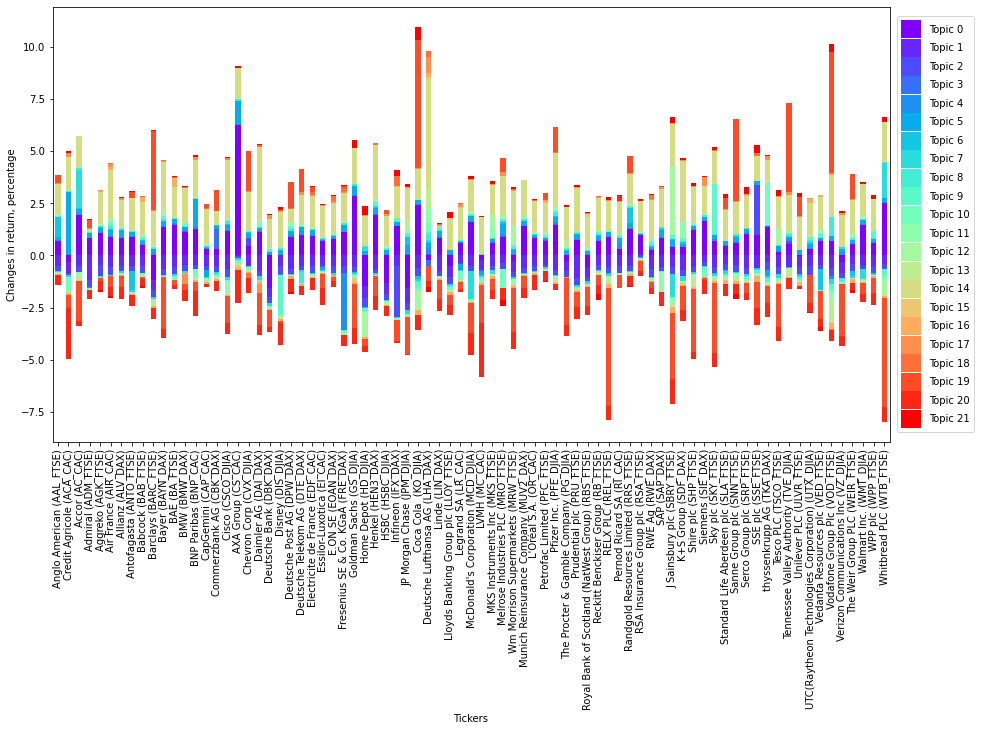

In [28]:
fig, ax = plt.subplots(
    nrows=1, 
    ncols=1,  
    figsize=(15, 8)) 


df_deltas.plot.bar(ax=ax, stacked=True, color=colors_topic)
lgd = ax.legend(bbox_to_anchor=(1.055, 0.99), loc="upper center", ncol=1, handleheight=2.4, labelspacing=0.05)

ax.set_ylabel("Changes in return, percentage")
ax.set_xlabel("Tickers")

#save plot
pp = PdfPages(os.path.join(PATHS['original_run_interpretation'], 'return_plots', 'n-1_returns_stack.pdf'))
plt.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
pp.close()

## Plot by pages

In [29]:
def print_deltas(df = {}, page=0, per_page=11, T=22):
    start = page * per_page
    end = start + per_page
    at_page = per_page if end <= number_of_topics else (per_page - (end - T))
    
    fig, axes = plt.subplots(
    nrows=at_page, 
    ncols=1,  
    sharex=True,
    figsize=(15, 25)) 
    
    for i in range(at_page): 
        t = i + start
            
        topic_name = 'Topic %s' % t
        colors = [color_north if x > 0 else color_south for x in df_deltas[topic_name]]
        df[topic_name].plot(ax=axes[i], kind='bar', label='index', color=colors, align='center', width=1.0);
        axes[i].set_title('%s (%s)' % (topic_name, top_words[t]));
        
        axes[i].set_ylabel("Changes in return, percentage")
        axes[i].set_xlabel("Tickers")

    #save plot
    pp = PdfPages(os.path.join(PATHS['original_run_interpretation'], 'return_plots', 'n-1_returns_page_%s.pdf' % page))
    plt.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    pp.close()

findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


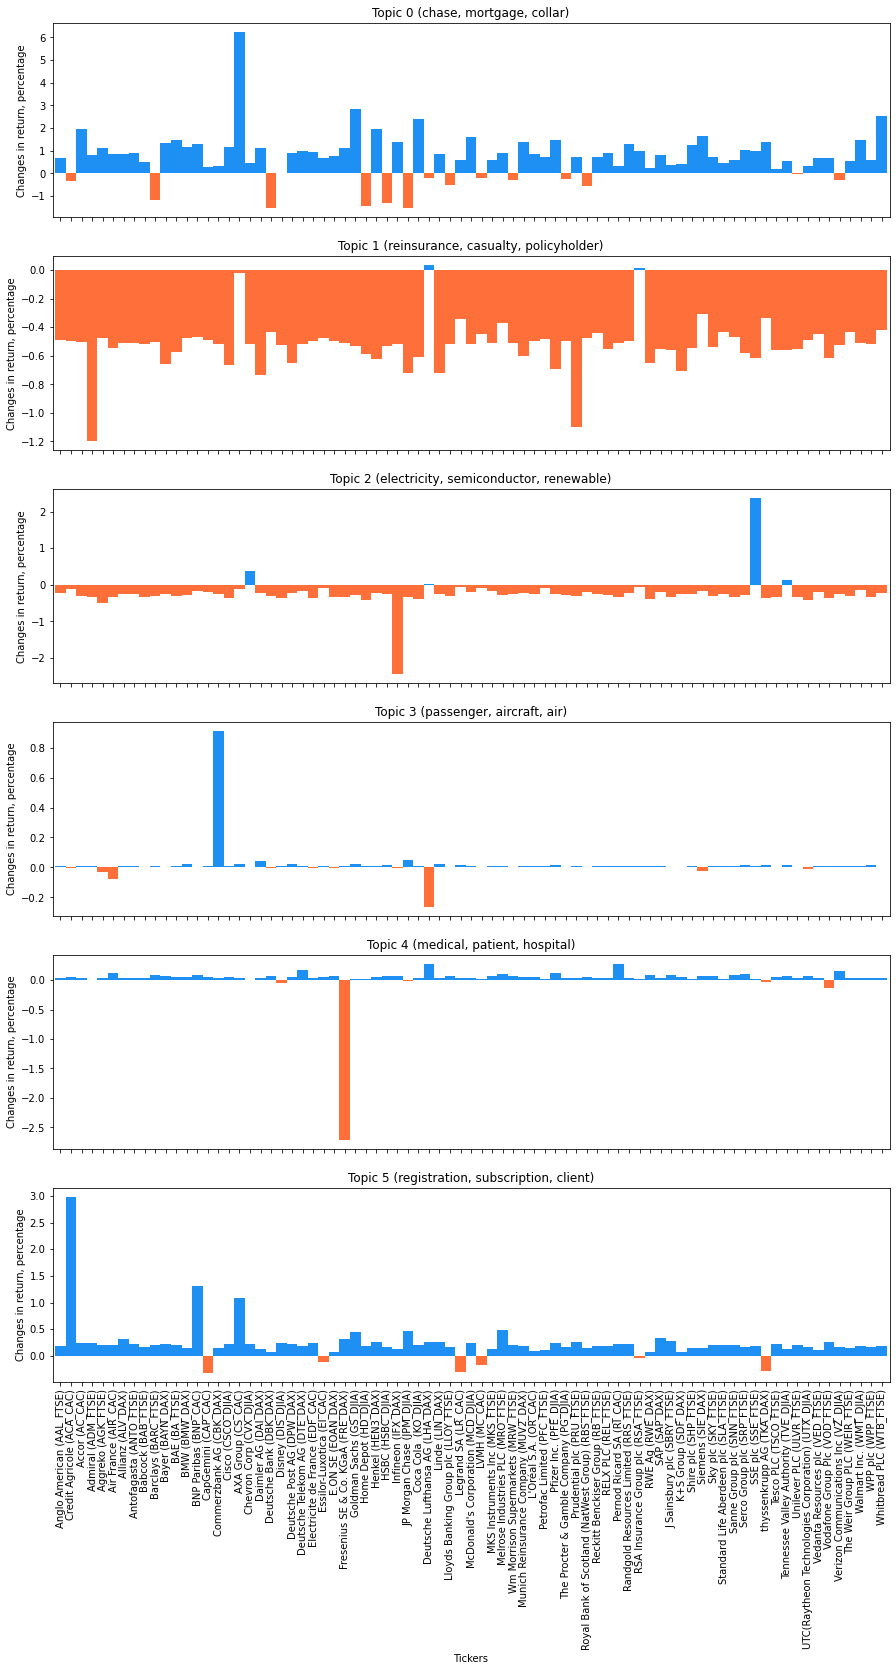

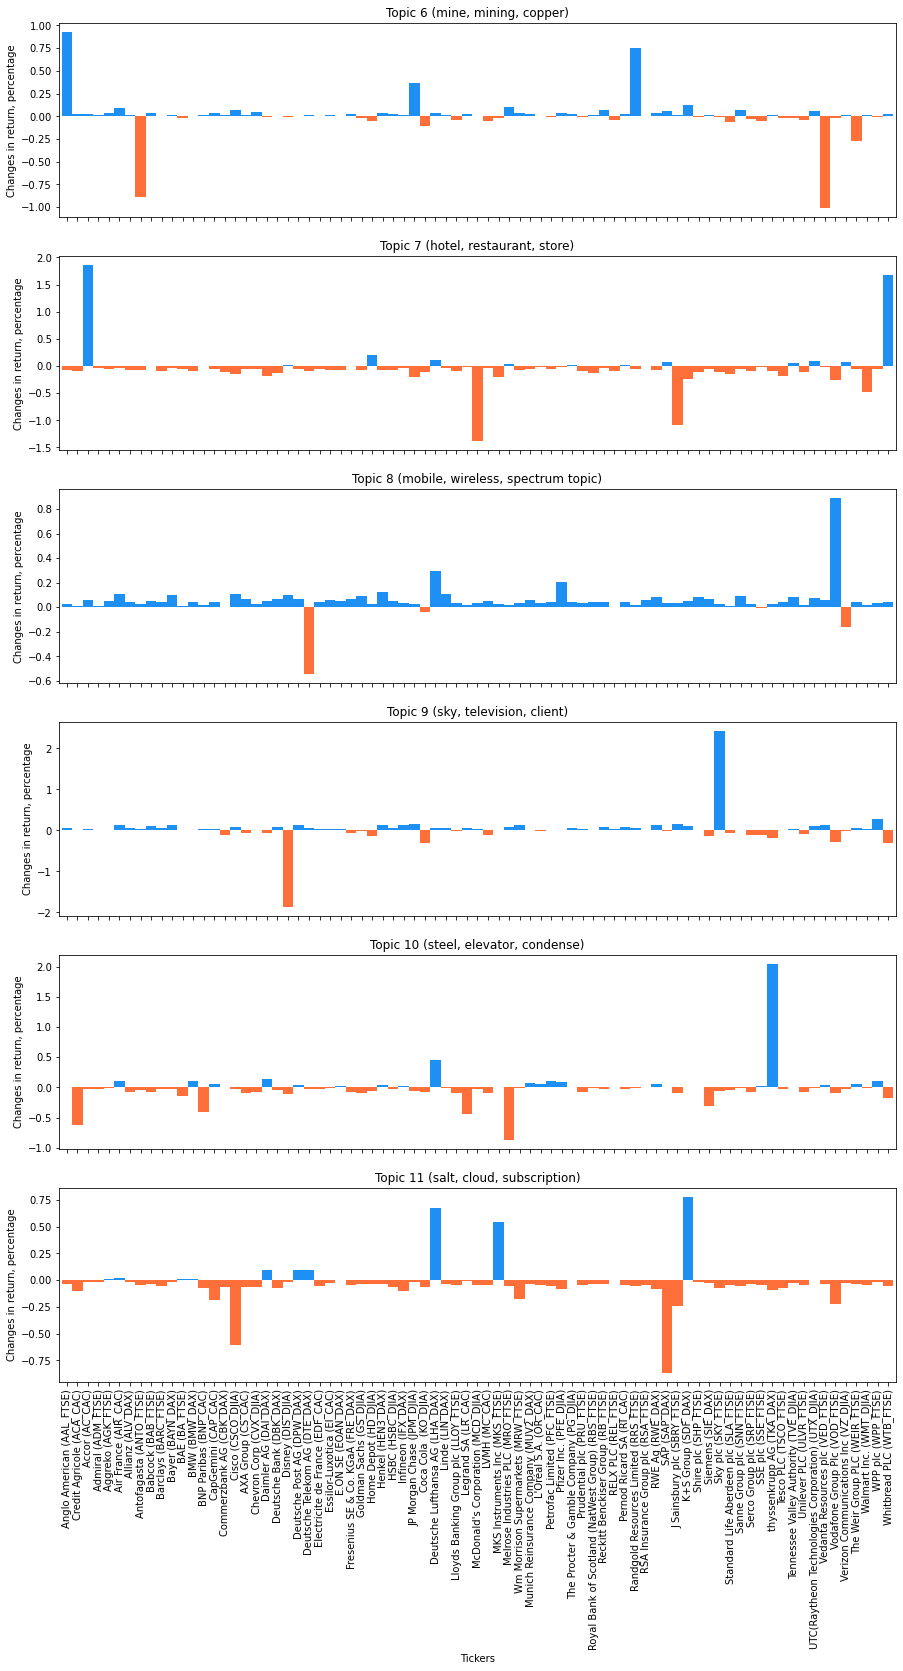

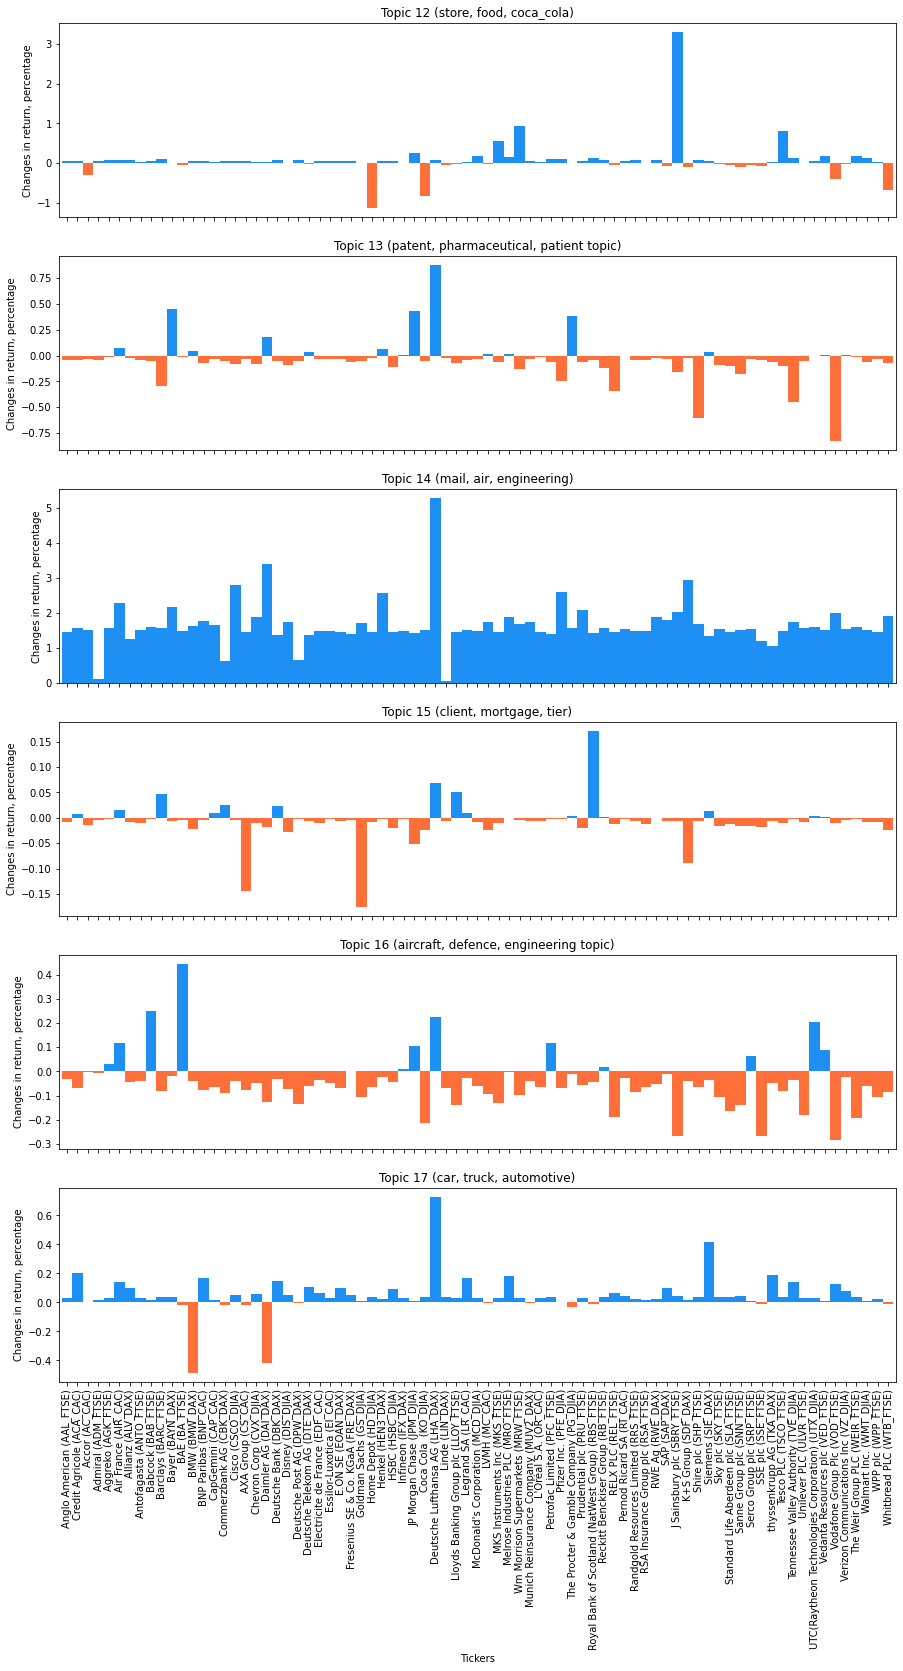

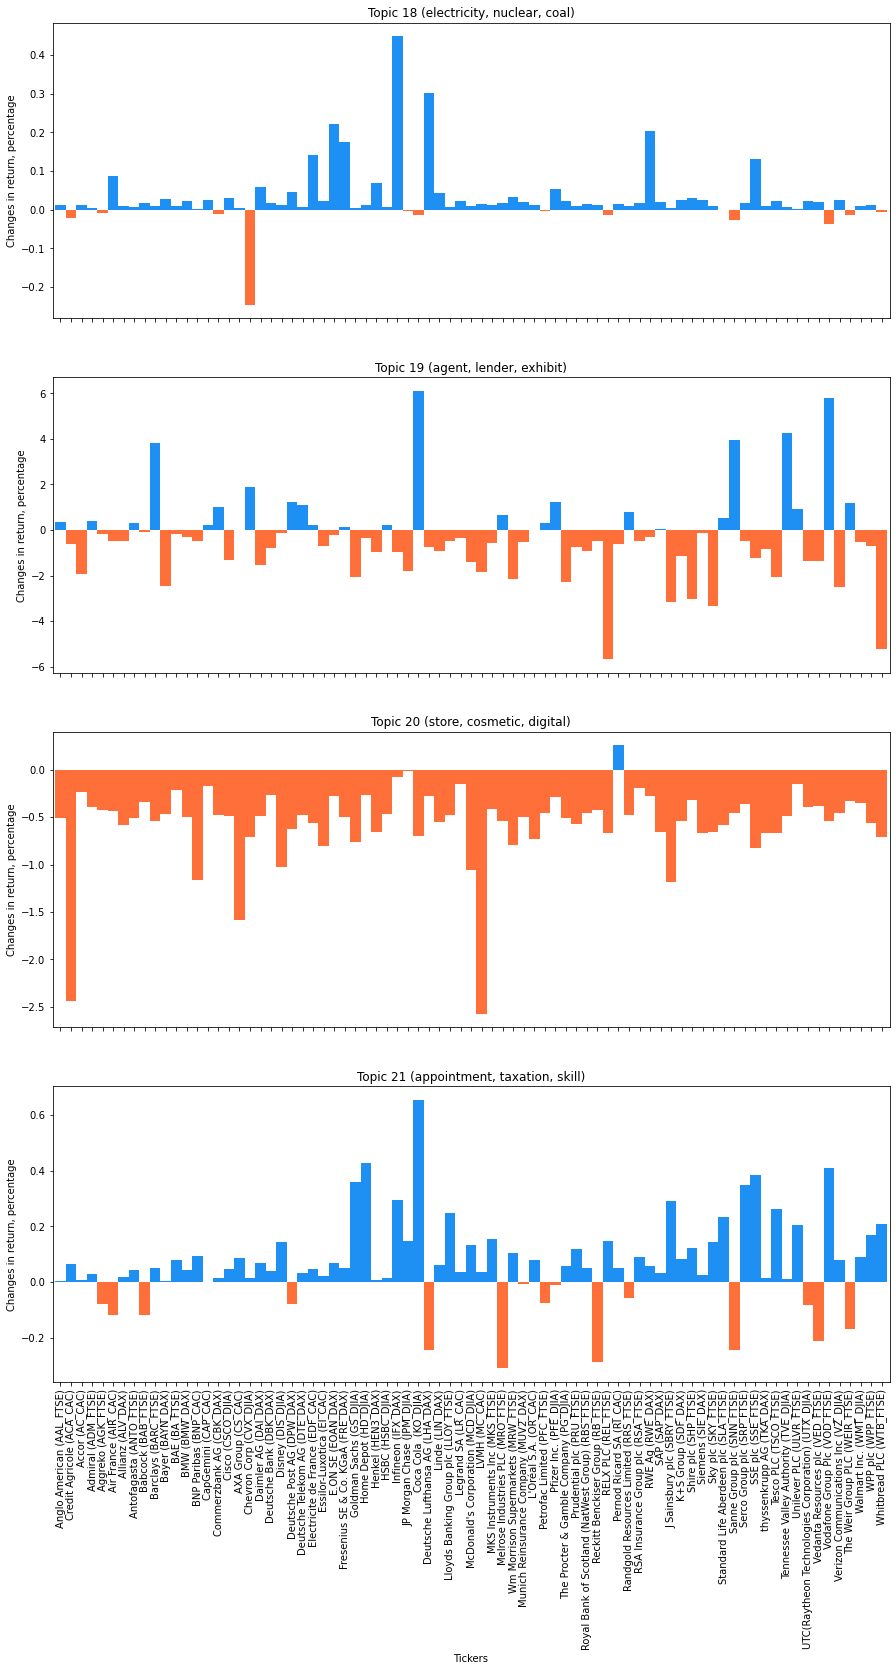

In [30]:
print_deltas(df=df_deltas, page=0, per_page=6)
print_deltas(df=df_deltas, page=1, per_page=6)
print_deltas(df=df_deltas, page=2, per_page=6)
print_deltas(df=df_deltas, page=3, per_page=6)